To-do:
- Make sure all libraries in for 3D -> 1D pharmacophore graph
- As in matrix calculations
- Network X

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign
from rdkit.Chem.Draw import MolsToGridImage
from pharmacophore import Pharmacophore, Draw, View


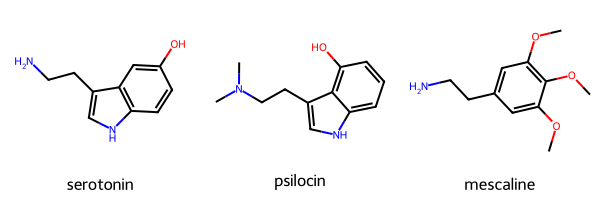

In [2]:
molecules = {"serotonin": "C1=CC2=C(C=C1O)C(=CN2)CCN",
             "psilocin": "CN(C)CCc1c[nH]c2cccc(O)c12",
             "mescaline": "O(c1cc(cc(OC)c1OC)CCN)C"}

mol_smi = [smi for smi in molecules.values()]
mol_name = [name for name in molecules.keys()]
mols = [Chem.MolFromSmiles(smi) for smi in mol_smi]

MolsToGridImage(mols=mols, legends=mol_name)

In [3]:
mols = [Chem.AddHs(mol) for mol in mols]
ps = AllChem.ETKDGv3()
ps.randomSeed = 42
for mol in mols:
    AllChem.EmbedMolecule(mol, ps)

In [4]:
aligned = []

for mol in mols:
    mol_aligned = rdMolAlign.GetO3A(mol, mols[0])
    aligned.append(mol_aligned.Align())

In [ ]:
# conformations stored as sdf files
# this is step 1
for mol, name in zip(mols, mol_name):
    w = Chem.SDWriter(f"data/{name}.sdf")
    w.write(mol)
    w.close()

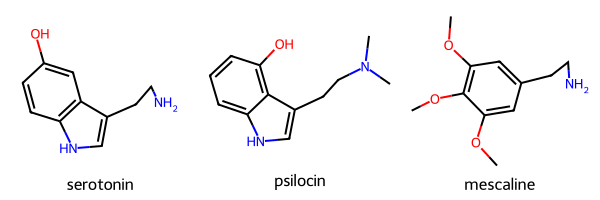

In [6]:
mols_noH = [Chem.RemoveHs(mol) for mol in mols]
MolsToGridImage(mols=mols_noH, legends=mol_name)

In [11]:
# test default and rdkit pharmacophore features: "default" and "rdkit"
PHARM_FEATURES = "rdkit"
pharm = Pharmacophore(features=PHARM_FEATURES)

# can test this also -- presence/absence of pharmacophore features
# simply binarized
df = pharm.to_df(mols_noH, mol_name=mol_name)
df

,serotonin,psilocin,mescaline
Donor,3,3,1
Acceptor,1,1,3
PosIonizable,1,1,1
Aromatic,2,2,1
Hydrophobe,3,3,2
LumpedHydrophobe,1,1,1


In [16]:
pharma_single = pharm.calc_pharm(mols_noH[2])
pharma_single

[['Donor', (13,), -2.7731599706014, 2.531199974695842, 0.0],
 ['Acceptor', (0,), -0.17176001485188802, -1.966799903233846, 0.0],
 ['Acceptor', (6,), 1.558039980570475, 1.034600014368693, 0.0],
 ['Acceptor', (9,), 1.559640017191569, -0.9654000619252522, 0.0],
 ['PosIonizable', (13,), -2.7731599706014, 2.531199974695842, 0.0],
 ['Aromatic',
  (1, 2, 3, 4, 5, 8),
  -0.17322667694091798,
  0.033199996630350836,
  0.0],
 ['Hydrophobe', (3,), -1.0397600072224935, 0.5326000067392986, 0.0],
 ['Hydrophobe', (11,), -1.9059599583943685, 1.0318000265757243, 0.0],
 ['LumpedHydrophobe',
  (1, 2, 3, 4, 5, 8),
  -0.17322667694091798,
  0.033199996630350836,
  0.0]]

In [ ]:
v=View()
pharma = []
for mol in mols_noH:
    pharma.append(pharm.calc_pharm(mol))
v.view(mols_noH, pharma, labels=True)

interactive(children=(Dropdown(description='Select:', options=(('Molecule 1', 0), ('Molecule 2', 1), ('Molecul…

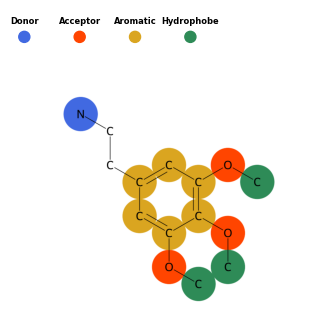

In [15]:
draw = Draw()
draw.draw_pharm(mols_noH[2])